In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../../WNTR_Model/')
sys.path.append('../DNN/')
from testWN import testWN as twm

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [4]:
from RNN_tools import get_model, keras2casadi
from surrogate_model_training_data import get_data

**Purpose of this notebook**

In this Jupyter Notebook we investigated the application of recurrent neural networks as surrogate models of the WNTR model. 
We used the same data-processing as for the dense neural network, which is investigated in depth in the [this](../DNN/dnn_surrogate_prototyping.ipynb) notebook. The pre-processing is outsourced into the file `surrogate_model_training_data.py`,  which is loaded above.

A major challenge for the application of LSTM / GRU (recurrent neural networks) is the significantly more complex model architecture, compared to the dense neural network. For the application of RNN surrogate models in our MPC framework we need to reimplement this architecture with the applied symbolic framework ([CasADi](https://web.casadi.org/docs/)). This reimplementation is part of `RNN_tools.py`. We investigate the conformity at the end of this script. 

The investigated pipeline of setting up and training a LSTM model is afterwards outsourced into the file `RNN_batch_training.py` which can be used to train multiple variants with different hyper parameters.

# Data Pre-Processing

Get clusters:

In [5]:
cluster_label_path = '../../clustering/'
cluster_labels = pd.read_json(cluster_label_path+'cluster_labels_25cl.json')
pressure_factor = pd.read_json(cluster_label_path+'pressure_factor_25cl.json')
n_clusters = 25

Get results:

**Note**: Due to size restrictions of the repository, we do not host the data used for training. However,this data can be easily created, with the python scripts in the `WNTR_Model` directory.

In [78]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_noControls/'
file_list = os.listdir(data_path)[:5]
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]
nn_input_list, nn_output_list = get_data(file_list, 0, cluster_labels, pressure_factor,
                                         narx_input=False, narx_output=False, return_lists=True)

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../../WNTR_Model/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



## Normalize Data:

Scaling factors:

In [79]:
input_scaling = pd.concat(nn_input_list).abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5

output_scaling = pd.concat(nn_output_list).abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5

In [80]:
nn_input_list_scaled = [nn_in_i/input_scaling for nn_in_i in nn_input_list]
nn_output_list_scaled = [nn_out_i/output_scaling for nn_out_i in nn_output_list]

In [81]:
input_scaling = input_scaling.to_numpy().reshape(1,-1)
output_scaling = output_scaling.to_numpy().reshape(1,-1)

## RNN I/O structure
All our recurrent neural networks are trained with the stateful setting **True**. The settings is explained [here](https://keras.io/examples/lstm_stateful/). In summary, after having trained on a given data sequence, we use the resulting hidden state to initialize the next sequence. This is beneficial, when a very long coherent sequence is chopped into chunks for training (due to memory restrictions). In practice this allows to train the network to incoroporate much older information than the horizon, as defined with `seq_length`, contains. 

The downside of stateful training is, that data pre-processing is becoming more complex, when using batches. 
In the code cell below, we are preparing the data for stateful training with `batch_size > 0`.

In [84]:
n_datasets = len(file_list)
seq_length = 20  # length of sequence for ANN training

n_data = nn_input_list[0].shape[0]
n_seq = n_data // seq_length - 1

# create sequences from the data:
X = []
Y = []
for data_i in range(n_datasets):
    X_train = nn_input_list_scaled[data_i].to_numpy()
    Y_train = nn_output_list_scaled[data_i].to_numpy()
    for offset in range(n_seq):
        for data_sample in range(n_seq-1):
            start_ind = data_sample*seq_length+offset
            X.append(X_train[start_ind:start_ind + seq_length, :])
            Y.append(Y_train[start_ind:start_ind + seq_length, :])

X = np.stack(X, axis=0)  # [m, seq_length, nx]
Y = np.stack(Y, axis=0)  # [m, seq_length, ny]

batch_size = n_seq*n_datasets
nx = X.shape[2]
ny = Y.shape[2]

We obtain the following training data shape:

In [85]:
X.shape

(5950, 20, 41)

Note that with the batch_size:

In [86]:
batch_size

175

We obtain:

In [87]:
X.shape[0]/batch_size

34.0

consecutive sequences for each batch. Since the training sequences are ~700 elements and we chose `seq_length=20` (20*34 = 680), this is the integer division.

# Create RNN
We rely on the implementation in `RNN_tools.py` to create the model. Which takes the `model_param` dict as defined below as input.

In [88]:
stateful = True
n_layer = 2  # hidden layer - output layer (linear) is automatically added
model_param = {}
model_param['RNN_param'] = {}
model_param['n_units'] = (n_layer) * [40]
model_param['p_dropout'] = None  # Placeholder. Not yet used.
model_param['activation'] = (n_layer) * ['tanh']

model_param['RNN_param']['RNN_type'] = 'LSTM'
model_param['RNN_param']['n_activation'] = 40
model_param['RNN_param']['recurrent_dropout'] = 0
model_param['RNN_param']['dropout'] = 0.
model_param['RNN_param']['implementation'] = 2

model = get_model(model_param, nx, ny, batch_size=batch_size,
                  seq_length=seq_length, stateful=stateful)

model.compile(loss='mse', optimizer='Adam')
model.summary()

No value selected for dropout, choosing do=0.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (175, 20, 40)             13120     
_________________________________________________________________
time_distributed_6 (TimeDist (175, 20, 40)             1640      
_________________________________________________________________
dropout_4 (Dropout)          (175, 20, 40)             0         
_________________________________________________________________
time_distributed_7 (TimeDist (175, 20, 40)             1640      
_________________________________________________________________
dropout_5 (Dropout)          (175, 20, 40)             0         
_________________________________________________________________
time_distributed_8 (TimeDist (175, 20, 37)             1517      
Total params: 17,917
Trainable params: 17,917
Non-trainable params: 0
____

It is important to introduce a reset callback to the `.fit()` method, when using stateful training. This callback is triggered after having processed the entire batch and sets the hidden input to zero. 

In [89]:
cb_reset = keras.callbacks.LambdaCallback(on_epoch_end=model.reset_states())

model.fit(X, Y, callbacks=[cb_reset], batch_size=batch_size,
          epochs=100, verbose=1, shuffle=not(stateful))

Train on 5950 samples
Epoch 1/100
5950/5950 [==============================] - 4s 741us/sample - loss: 0.2006
Epoch 2/100
5950/5950 [==============================] - 1s 246us/sample - loss: 0.0457
Epoch 3/100
5950/5950 [==============================] - 1s 239us/sample - loss: 0.0426
Epoch 4/100
5950/5950 [==============================] - 1s 233us/sample - loss: 0.0396
Epoch 5/100
5950/5950 [==============================] - 2s 260us/sample - loss: 0.0345
Epoch 6/100
5950/5950 [==============================] - 1s 243us/sample - loss: 0.0296
Epoch 7/100
5950/5950 [==============================] - 1s 249us/sample - loss: 0.0259
Epoch 8/100
5950/5950 [==============================] - 1s 231us/sample - loss: 0.0224
Epoch 9/100
5950/5950 [==============================] - 1s 238us/sample - loss: 0.0191
Epoch 10/100
5950/5950 [==============================] - 2s 269us/sample - loss: 0.0165
Epoch 11/100
5950/5950 [==============================] - 2s 263us/sample - loss: 0.0145
Epoch 12

Epoch 93/100
5950/5950 [==============================] - 3s 449us/sample - loss: 0.0038
Epoch 94/100
5950/5950 [==============================] - 3s 516us/sample - loss: 0.0038
Epoch 95/100
5950/5950 [==============================] - 2s 404us/sample - loss: 0.0038
Epoch 96/100
5950/5950 [==============================] - 2s 370us/sample - loss: 0.0038
Epoch 97/100
5950/5950 [==============================] - 2s 391us/sample - loss: 0.0038
Epoch 98/100
5950/5950 [==============================] - 2s 393us/sample - loss: 0.0037
Epoch 99/100
5950/5950 [==============================] - 2s 359us/sample - loss: 0.0037
Epoch 100/100
5950/5950 [==============================] - 3s 436us/sample - loss: 0.0037


# Evaluate Model

To evaluate the model, we create a similar structure but with `seq_length=1` and `batch_size=1`. The weights are taken from the trained model. This model can be evaluated recursiveley (with a single sequence element as input) and keeps track of the hidden state itself.

In [90]:
model_simple = get_model(model_param, nx, ny, batch_size=1,
                         seq_length=1, stateful=stateful)

model_simple.set_weights(model.get_weights())

model_simple.summary()
model_simple.reset_states()

No value selected for dropout, choosing do=0.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (1, 1, 40)                13120     
_________________________________________________________________
time_distributed_9 (TimeDist (1, 1, 40)                1640      
_________________________________________________________________
dropout_6 (Dropout)          (1, 1, 40)                0         
_________________________________________________________________
time_distributed_10 (TimeDis (1, 1, 40)                1640      
_________________________________________________________________
dropout_7 (Dropout)          (1, 1, 40)                0         
_________________________________________________________________
time_distributed_11 (TimeDis (1, 1, 37)                1517      
Total params: 17,917
Trainable params: 17,917
Non-trainable params: 0
____

**Initialize hidden state:**
For a more accurate evaluation of the model performance, we initilize the hidden state by evaluating the model repeatedly with a true sequence of inputs.

In [92]:
model_simple.reset_states()
test_with = 0
nn_input = nn_input_list_scaled[test_with]
sys_states = nn_input_list[test_with]['sys_states']
sys_inputs = nn_input_list[test_with]['sys_inputs']
# Initialize hidden state:
t = 0
dt = 3600
for i,in_i in nn_input.iloc[:seq_length].iterrows():
    rnn_in_scaled = in_i.to_numpy().reshape(1,-1)
    model_simple.predict(rnn_in_scaled.reshape(1,1,-1))
    t += dt

The real evaluation is an open-loop "simulation". For a given intial state and a sequence of inputs, we predict the sequence of states (similarly as for the DNN investigation).

In [93]:
x_arr = [sys_states.iloc[seq_length].to_numpy().reshape(1,-1)]
t_arr = [t]
for i,u_i in sys_inputs.iloc[seq_length:].iterrows():
    rnn_in_i = np.concatenate((x_arr[-1],u_i.to_numpy().reshape(1,-1)),axis=1)
    rnn_in_scaled = (rnn_in_i)/input_scaling
    rnn_out_scaled = model_simple.predict(rnn_in_scaled.reshape(1,1,-1))
    rnn_out = rnn_out_scaled.squeeze()*output_scaling
    t_arr.append(t_arr[-1]+dt)
    x_arr.append(x_arr[-1]+rnn_out[[0],:7])
    
res = np.concatenate(x_arr)

In [94]:
res = pd.DataFrame(res, columns=sys_states.columns, index=t_arr)

<IPython.core.display.Javascript object>


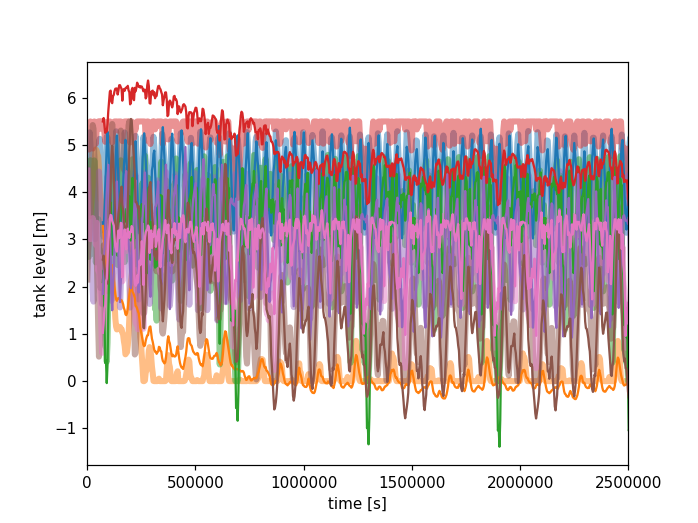

Text(0.5, 0, 'time [s]')

In [97]:
fig, ax = plt.subplots(1,1, sharex=True)

sys_states['tank_press'].plot(ax=ax, legend=False, alpha=0.5, linewidth=4)
ax.set_prop_cycle(None)
res['tank_press'].plot(ax=ax, legend=False)

ax.set_xlim(0, 2.5e6)

ax.set_ylabel('tank level [m]')
ax.set_xlabel('time [s]')

We see that qualitatively, the results are good. The error is still too large, however, for the control application. Especially, since we are investigating on a known sequence of inputs in this evaluation.

# Keras 2 Casadi

We investigate whether the CasADi model is valid. It is simply a re-implementation of the keras sequence models with CasADi symbolic variables.

In [49]:
from casadi import *

In [50]:
config = model_simple.get_config()
weights = model_simple.get_weights()

In [53]:
x_cas_in = MX.sym('x', 1, 41)
h_cas_in = MX.sym('h', 1, 40)
c_cas_in = MX.sym('c', 1, 40)

[x_cas_out, h_cas_out, c_cas_out], _ = keras2casadi(
    weights, config['layers'], [x_cas_in, h_cas_in, c_cas_in], backend_name='casadi')
fun = Function('fun', [x_cas_in, h_cas_in, c_cas_in], [x_cas_out, h_cas_out, c_cas_out])

In [54]:
x = np.ones((1, 41))
h = np.zeros((1, 40))
c = np.zeros((1, 40))

In [4]:
x = np.ones((1, 41))
x_casadi,h,c = fun(x,h,c)

In [56]:
x_casadi.full()

array([[ 3.987e-02, -2.542e-01, -3.518e-01, -2.519e-01,  2.845e-02, -4.546e-01, -6.991e-02,  4.584e-01,  4.601e-01,  1.023e+00,  9.228e-01,  9.033e-01,  3.850e-02, -3.604e-06,  6.484e-01,  2.807e-01,  4.868e-01,  4.837e-01,  3.252e-01,  4.991e-01,  3.062e-01,  1.520e-01,  9.704e-02,  5.027e-01,
         4.320e-02,  2.554e-01,  2.325e-01,  2.110e-01,  3.727e-01,  5.020e-01, -5.685e-02,  4.700e-01,  3.710e-01,  8.783e-02,  3.837e-01,  3.223e-01,  4.437e-01]])

In [57]:
model_simple.reset_states()

In [58]:
x_keras = np.ones((1, 41))
model_simple.predict(x.reshape(1,1,-1))

array([[[ 3.987e-02, -2.542e-01, -3.518e-01, -2.519e-01,  2.845e-02, -4.546e-01, -6.991e-02,  4.584e-01,  4.601e-01,  1.023e+00,  9.228e-01,  9.033e-01,  3.850e-02, -3.557e-06,  6.484e-01,  2.807e-01,  4.868e-01,  4.837e-01,  3.252e-01,  4.991e-01,  3.062e-01,  1.520e-01,  9.704e-02,  5.027e-01,
          4.320e-02,  2.554e-01,  2.325e-01,  2.110e-01,  3.727e-01,  5.020e-01, -5.685e-02,  4.700e-01,  3.710e-01,  8.783e-02,  3.837e-01,  3.223e-01,  4.437e-01]]], dtype=float32)